# Boxes in Object Detection 

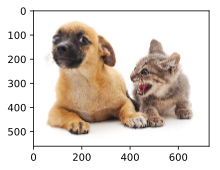

In [1]:
%matplotlib inline
import d2l
from mxnet import image, nd, contrib

d2l.set_figsize()
img = image.imread('catdog.jpg').asnumpy()
d2l.plt.imshow(img)

## Bounding Box

A bounding box can be defined by (top-left x, top-left y, bottom-right x, bottom-right y)

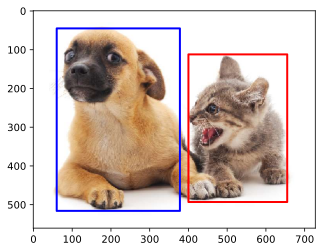

In [2]:
dog_bbox, cat_bbox = [60, 45, 378, 516], [400, 112, 655, 493]

def bbox_to_rect(bbox, color): 
    # Convert to matplotlib format: ((upper-left x, upper-left y), width, height).
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## Anchor Boxes

Utility functions to draw multiple boxes in an image. 

In [3]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.asnumpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

Anchor boxes centered on (250, 250)


[0.05511677 0.07152405 0.63307005 0.821524  ]
<NDArray 4 @cpu(0)>


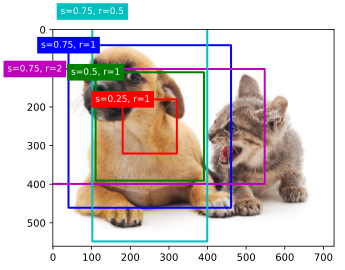

In [4]:
h, w = img.shape[0:2]
X = nd.random.uniform(shape=(1, 3, h, w))  # Construct input data.
Y = contrib.nd.MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
boxes = Y.reshape((h, w, 5, 4))
print(boxes[250, 250, 0, :])

bbox_scale = nd.array((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

## Labeling Training Set Anchor Boxes

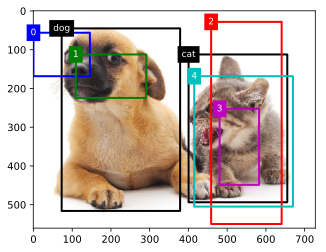

In [5]:
ground_truth = nd.array([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = nd.array([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

Map each anchor box to a bounding box or background

In [6]:
labels = contrib.nd.MultiBoxTarget(anchors.expand_dims(axis=0),
                                   ground_truth.expand_dims(axis=0),
                                   nd.zeros((1, 3, 5)))
# assigned labels: (batch_size, #anchors)
print(labels[2])
# masks: (batch_size, 4 x #anchors), 0 for background, 1 for object
print(labels[1])
# offset to bounding boxes: (batch_size, 4 x #anchors)
print(labels[0])


[[0. 1. 2. 0. 2.]]
<NDArray 1x5 @cpu(0)>

[[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]]
<NDArray 1x20 @cpu(0)>

[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.3999999e+00  9.9999990e+00  2.5939689e+00  7.1754227e+00
  -1.1999989e+00  2.6881757e-01  1.6823606e+00 -1.5654588e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -5.7142794e-01 -1.0000001e+00 -8.9406973e-07  6.2581623e-01]]
<NDArray 1x20 @cpu(0)>


## Output Bounding Boxes for Prediction

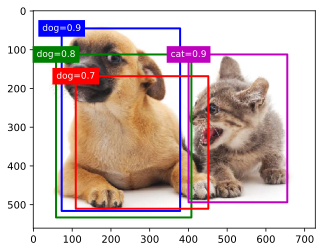

In [7]:
anchors = nd.array([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                    [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = nd.array([0] * anchors.size)
cls_probs = nd.array([[0] * 4,  # Predicted probability for background
                      [0.9, 0.8, 0.7, 0.1],  # Predicted probability for dog
                      [0.1, 0.2, 0.3, 0.9]])  # Predicted probability for cat
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

Non-maximum suppression:

In [8]:
import numpy as np
np.set_printoptions(2)

output = contrib.ndarray.MultiBoxDetection(
    cls_probs.expand_dims(axis=0), offset_preds.expand_dims(axis=0),
    anchors.expand_dims(axis=0), nms_threshold=0.5)
output


[[[ 0.    0.9   0.1   0.08  0.52  0.92]
  [ 1.    0.9   0.55  0.2   0.9   0.88]
  [-1.    0.8   0.08  0.2   0.56  0.95]
  [-1.    0.7   0.15  0.3   0.62  0.91]]]
<NDArray 1x4x6 @cpu(0)>

Visualize the results

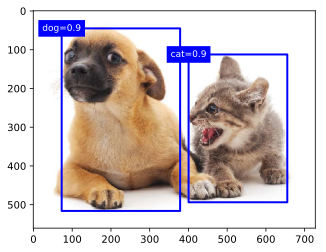

In [9]:
fig = d2l.plt.imshow(img)
for i in output[0].asnumpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [nd.array(i[2:]) * bbox_scale], label)

## Multiscale Object Detection

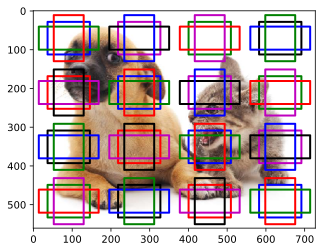

In [10]:
def display_anchors(fmap_w, fmap_h, s):
    fmap = nd.zeros((1, 10, fmap_w, fmap_h))  # The values from the first two dimensions will not affect the output.
    anchors = contrib.nd.MultiBoxPrior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = nd.array((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes, anchors[0] * bbox_scale)
    
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

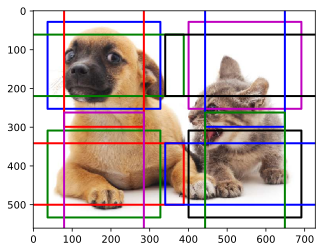

In [11]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

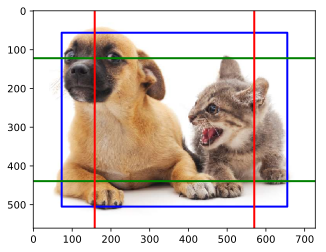

In [12]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])